<a href="https://colab.research.google.com/github/nantawat23308/LinearRegression/blob/main/Linear_Model_and_tuning_Concrete_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC, SVR

from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

# metric
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix

from scipy.stats import pearsonr, spearmanr, kendalltau

In [3]:
concrete_data_path = "/content/drive/MyDrive/Concrete_Data.xls"

In [4]:
data = pd.read_excel(concrete_data_path, index_col = None)
 ## ข้อมูลนี้ไม่มี row index
data.columns = [x.split('(')[0].strip() for x in data.columns] ## ปรับชื่อคอลัมน์ให้กระชับ
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [5]:
data.shape

(1030, 9)

In [6]:
input_data = data.iloc[:, :-1]
output_data = data.iloc[:, -1]

# Correlation
*   Pearson's linear correlation
*   Spearman's rank correlation
*   Kendall's tau

In [7]:
correlations = pd.DataFrame(0, index = input_data.columns, columns = ['Pearson', 'Spearman', 'Kendall'])

for x in input_data.columns:
    correlations.loc[x, :] = [pearsonr(input_data[x], output_data)[0], ## ฟังก์ชันเหล่านี้จะคืนค่า correlation และ p-value
                              spearmanr(input_data[x], output_data)[0],
                              kendalltau(input_data[x], output_data)[0]]

correlations.head(10)

<ipython-input-7-141e2c68fad2>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.497832722274844' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  correlations.loc[x, :] = [pearsonr(input_data[x], output_data)[0], ## ฟังก์ชันเหล่านี้จะคืนค่า correlation และ p-value
<ipython-input-7-141e2c68fad2>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4776011569132234' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  correlations.loc[x, :] = [pearsonr(input_data[x], output_data)[0], ## ฟังก์ชันเหล่านี้จะคืนค่า correlation และ p-value
<ipython-input-7-141e2c68fad2>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.32713816361170345' has dtype incompatible with int64, 

,Pearson,Spearman,Kendall
Cement,0.497833,0.477601,0.327138
Blast Furnace Slag,0.134824,0.162473,0.118005
Fly Ash,-0.105753,-0.077957,-0.059708
Water,-0.289613,-0.308371,-0.206010
Superplasticizer,0.366102,0.347589,0.249057
Coarse Aggregate,-0.164928,-0.183516,-0.123722
Fine Aggregate,-0.167249,-0.179991,-0.122260
Age,0.328877,0.596020,0.449016


# Split Model Selection

In [8]:
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.2, random_state = 4649)

print('train data shape:', X_train.shape)
print('test data shape:', X_test.shape)

train data shape: (824, 8)
test data shape: (206, 8)


## Cross Validation

In [9]:
cv_splitter = KFold(n_splits = 5, shuffle = True, random_state = 4649)

for train_index, test_index in cv_splitter.split(X_train):
    print('train size:', train_index.shape, 'test size:', test_index.shape)

train size: (659,) test size: (165,)
train size: (659,) test size: (165,)
train size: (659,) test size: (165,)
train size: (659,) test size: (165,)
train size: (660,) test size: (164,)


## Standardize

In [10]:
# mean and std
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(X_train)
# have to 2D array 1 columns
y_scaler.fit(y_train.values.reshape(-1, 1))

StandardScaler()

In [11]:
x_train_std = x_scaler.transform(X_train)
x_test_std = x_scaler.transform(X_test)
y_train_std = y_scaler.transform(y_train.values.reshape(-1, 1))
y_test_std = y_scaler.transform(y_test.values.reshape(-1,1))

In [12]:
x_train_std = pd.DataFrame(x_train_std, columns = X_train.columns, index = X_train.index)
x_test_std = pd.DataFrame(x_test_std, columns = X_test.columns, index = X_test.index)

In [13]:
x_train_std.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
623,0.239345,-0.857451,-0.821466,0.523296,-1.017143,-0.072154,0.497311,-0.670388
701,0.054786,1.339107,-0.821466,0.476942,-1.017143,-0.540343,-0.687716,0.654713
652,-1.751948,0.892931,-0.821466,0.476942,-1.017143,-1.125578,2.132698,-0.670388
271,-0.491605,-0.857451,1.085617,-0.359296,0.100427,1.077508,0.075255,-0.289612
553,-0.415353,3.254232,-0.821466,0.184908,-1.017143,-0.415492,-1.360740,-0.609463


# Train Model

In [14]:
base_linear = LinearRegression()
base_ridge = Ridge(alpha = 1.0, random_state = 4649)
base_lasso = Lasso(alpha = 1.0, random_state = 4649)

In [15]:
base_linear.fit(x_train_std, y_train_std)
base_ridge.fit(x_train_std, y_train_std)
base_lasso.fit(x_train_std, y_train_std)

Lasso(random_state=4649)

## Predict training and test set

In [16]:
base_linear_pred_train = base_linear.predict(x_train_std)
base_ridge_pred_train = base_ridge.predict(x_train_std)
base_lasso_pred_train = base_lasso.predict(x_train_std)

In [17]:
base_linear_pred_test = base_linear.predict(x_test_std)
base_ridge_pred_test = base_ridge.predict(x_test_std)
base_lasso_pred_test = base_lasso.predict(x_test_std)

In [18]:
meas = pd.DataFrame(0, index = ['Linear', 'Ridge', 'Lasso'], columns = ['Train', 'Test'])
meas.loc['Linear', :] = [mean_absolute_error(y_train_std, base_linear_pred_train), mean_absolute_error(y_test_std, base_linear_pred_test)]
meas.loc['Ridge', :] = [mean_absolute_error(y_train_std, base_ridge_pred_train), mean_absolute_error(y_test_std, base_ridge_pred_test)]
meas.loc['Lasso', :] = [mean_absolute_error(y_train_std, base_lasso_pred_train), mean_absolute_error(y_test_std, base_lasso_pred_test)]
meas.head()

<ipython-input-18-04f37d5514be>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.502354843510039' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  meas.loc['Linear', :] = [mean_absolute_error(y_train_std, base_linear_pred_train), mean_absolute_error(y_test_std, base_linear_pred_test)]
<ipython-input-18-04f37d5514be>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.43775298069443275' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  meas.loc['Linear', :] = [mean_absolute_error(y_train_std, base_linear_pred_train), mean_absolute_error(y_test_std, base_linear_pred_test)]


,Train,Test
Linear,0.502355,0.437753
Ridge,0.502674,0.438234
Lasso,0.807707,0.773037


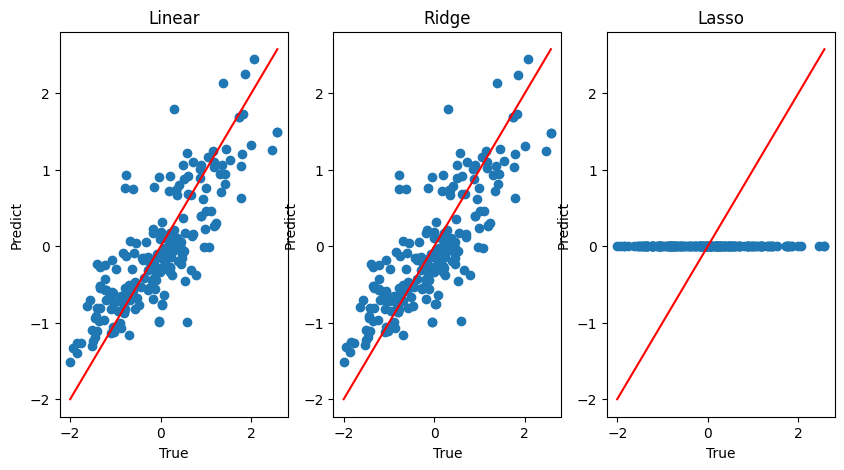

In [19]:
plt.figure(figsize = (10, 5))
plt.subplot(1,3,1)
plt.scatter(y_test_std, base_linear_pred_test, label = 'Linear')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Linear')
plt.subplot(1,3,2)
plt.scatter(y_test_std, base_ridge_pred_test, label = 'Ridge')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Ridge')
plt.subplot(1,3,3)
plt.scatter(y_test_std, base_lasso_pred_test, label = 'Lasso')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Lasso')
plt.show()

In [20]:
meas.head()

,Train,Test
Linear,0.502355,0.437753
Ridge,0.502674,0.438234
Lasso,0.807707,0.773037


## Scale unit back

In [24]:
meas = meas * y_scaler.scale_[0]
meas.head()

,Train,Test
Linear,8.449978,7.363327
Ridge,8.455344,7.371424
Lasso,13.586232,13.003051


linear error out off real point 8.44 unit and etc

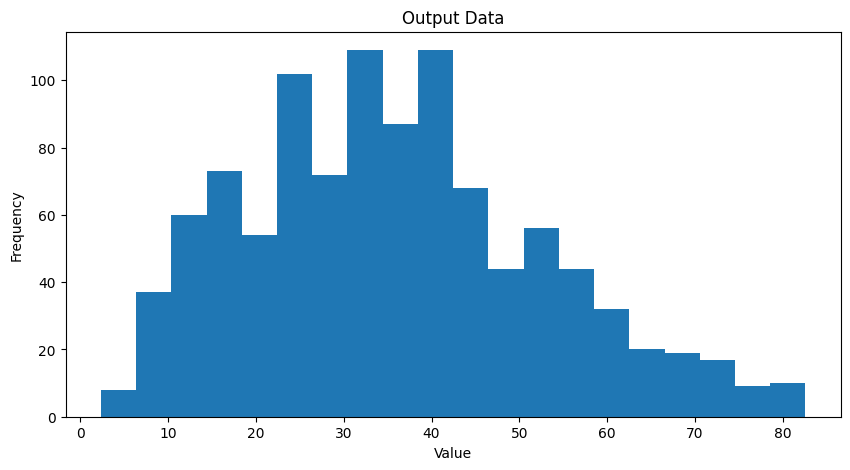

In [29]:
plt.figure(figsize=(10,5))
plt.hist(output_data, bins=20)
plt.title("Output Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Tuning Model

## tunning Lasso

In [30]:
param = {"alpha": [0.0001, 0.001, 0.01]}
scor = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"]

grid_lasso = GridSearchCV(estimator = base_lasso,
                          param_grid = param,
                          scoring = scor,
                          cv = cv_splitter,
                          refit = "neg_mean_absolute_error",
                          verbose = 1)

In [31]:
grid_lasso.fit(x_train_std, y_train_std)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=Lasso(random_state=4649),
             param_grid={'alpha': [0.0001, 0.001, 0.01]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'],
             verbose=1)

In [35]:
grid_lasso.cv_results_

{'mean_fit_time': array([0.00735674, 0.00352178, 0.00296717]),
 'std_fit_time': array([1.44407137e-03, 3.49576264e-04, 8.58404101e-05]),
 'mean_score_time': array([0.00389938, 0.00235176, 0.00220761]),
 'std_score_time': array([9.38483082e-04, 1.52640855e-04, 4.77731819e-05]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01],
              mask=[False, False, False],
        fill_value=1e+20),
 'params': [{'alpha': 0.0001}, {'alpha': 0.001}, {'alpha': 0.01}],
 'split0_test_neg_mean_absolute_error': array([-0.51871901, -0.51950993, -0.52266296]),
 'split1_test_neg_mean_absolute_error': array([-0.44999018, -0.45052897, -0.45174983]),
 'split2_test_neg_mean_absolute_error': array([-0.57623886, -0.57681398, -0.58174879]),
 'split3_test_neg_mean_absolute_error': array([-0.47801927, -0.47923725, -0.48393967]),
 'split4_test_neg_mean_absolute_error': array([-0.52086899, -0.52053659, -0.52075233]),
 'mean_test_neg_mean_absolute_error': array([-0.50876726, -0.50932534, -0.51217071]),
 's

In [36]:
grid_lasso_result = pd.DataFrame(grid_lasso.cv_results_)
grid_lasso_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0.007357,0.001444,0.003899,0.000938,0.0001,{'alpha': 0.0001},-0.518719,-0.449990,-0.576239,-0.478019,...,0.042891,1,-1.556146,-1.775108,-2.693315,-1.107109,-1.428786,-1.712093,0.536164,2
1,0.003522,0.000350,0.002352,0.000153,0.0010,{'alpha': 0.001},-0.519510,-0.450529,-0.576814,-0.479237,...,0.042770,2,-1.554951,-1.770177,-2.704649,-1.106956,-1.426632,-1.712673,0.540539,3
2,0.002967,0.000086,0.002208,0.000048,0.0100,{'alpha': 0.01},-0.522663,-0.451750,-0.581749,-0.483940,...,0.043526,3,-1.509234,-1.713303,-2.749035,-1.083405,-1.405834,-1.692162,0.566297,1


In [41]:
grid_lasso_result.sort_values(by = "rank_test_neg_mean_absolute_error")[["param_alpha", "mean_test_neg_mean_absolute_error", "std_test_neg_mean_absolute_error"]].head()

,param_alpha,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
0,0.0001,-0.508767,0.042891
1,0.0010,-0.509325,0.042770
2,0.0100,-0.512171,0.043526


In [45]:
grid_lasso.best_estimator_

Lasso(alpha=0.0001, random_state=4649)

In [44]:
# after tuning use alpha 0.0001
grid_lasso_pred_test = grid_lasso.predict(x_test_std)
print(f"MAE: {mean_absolute_error(y_test_std, grid_lasso_pred_test)}")

MAE: 0.43783811700401465


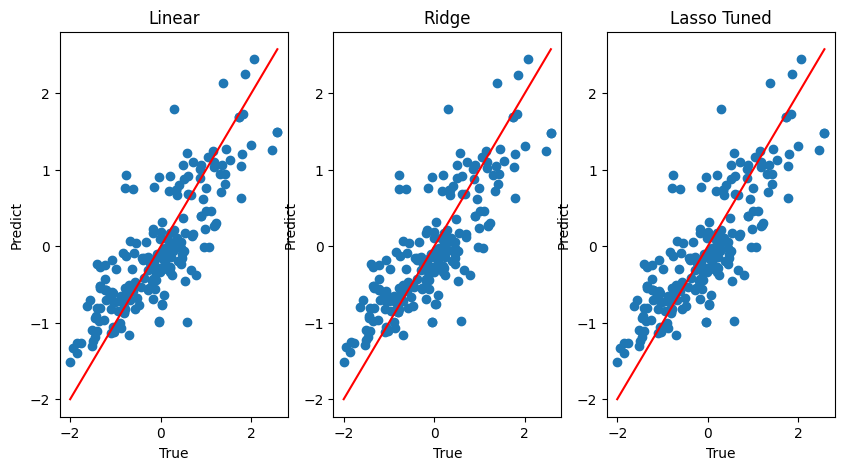

In [46]:
plt.figure(figsize = (10, 5))
plt.subplot(1,3,1)
plt.scatter(y_test_std, base_linear_pred_test, label = 'Linear')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Linear')
plt.subplot(1,3,2)
plt.scatter(y_test_std, base_ridge_pred_test, label = 'Ridge')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Ridge')
plt.subplot(1,3,3)
plt.scatter(y_test_std, grid_lasso_pred_test, label = 'Lasso')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Lasso Tuned')
plt.show()

result no difference

# Suppoer Vector Machine

In [47]:
# kernel 'rbf'
rbf_svr = SVR(kernel = 'rbf')

In [49]:
param = {"epsilon": np.arange(0, 0.21, 0.05), "C": np.power(10, np.linspace(-3, 3, 5))}
scor = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error"]

In [50]:
grid_rbf_svr = GridSearchCV(estimator = rbf_svr,
                            param_grid=param,
                            scoring=scor,
                            cv=cv_splitter,
                            refit="neg_mean_absolute_error",
                            verbose=1
                            )

In [52]:
# y have to be 1D array
grid_rbf_svr.fit(x_train_std, y_train_std.reshape([-1,]))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4649, shuffle=True),
             estimator=SVR(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'epsilon': array([0.  , 0.05, 0.1 , 0.15, 0.2 ])},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'],
             verbose=1)

In [55]:
grid_rbf_svr_result = pd.DataFrame.from_dict(grid_rbf_svr.cv_results_)
grid_rbf_svr_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0.014854,0.001246,0.005390,0.000109,0.001,0.00,"{'C': 0.001, 'epsilon': 0.0}",-0.783577,-0.740669,-0.825178,...,0.038682,21,-1.139020,-1.122638,-1.132177,-0.983103,-1.056760,-1.086740,0.059541,19
1,0.013594,0.000095,0.005209,0.000197,0.001,0.05,"{'C': 0.001, 'epsilon': 0.05}",-0.783563,-0.741421,-0.825189,...,0.038841,22,-1.132720,-1.088864,-1.096086,-0.981820,-1.040560,-1.068010,0.052140,18
2,0.014747,0.001302,0.005493,0.000224,0.001,0.10,"{'C': 0.001, 'epsilon': 0.1}",-0.783149,-0.742429,-0.825858,...,0.039820,23,-1.103077,-1.039299,-1.056727,-0.967603,-1.026170,-1.038575,0.044003,15
3,0.012823,0.000204,0.004987,0.000161,0.001,0.15,"{'C': 0.001, 'epsilon': 0.15000000000000002}",-0.782926,-0.743319,-0.827145,...,0.040054,24,-1.061562,-1.015147,-1.029221,-0.966150,-1.008119,-1.016040,0.030979,12
4,0.012196,0.000225,0.004795,0.000160,0.001,0.20,"{'C': 0.001, 'epsilon': 0.2}",-0.783303,-0.743469,-0.827569,...,0.040113,25,-1.067764,-1.017936,-1.025466,-0.967472,-1.020694,-1.019867,0.031859,13


In [56]:
grid_rbf_svr_result.sort_values(by = "rank_test_neg_mean_absolute_error")[["param_C", "param_epsilon", "mean_test_neg_mean_absolute_error", "std_test_neg_mean_absolute_error"]].head()

,param_C,param_epsilon,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error
16,31.622777,0.05,-0.249800,0.015814
15,31.622777,0.00,-0.250934,0.015421
17,31.622777,0.10,-0.252405,0.017525
18,31.622777,0.15,-0.255579,0.016228
19,31.622777,0.20,-0.256894,0.014943


In [57]:
grid_rbf_svr.best_estimator_

SVR(C=31.622776601683793, epsilon=0.05)

In [58]:
grid_rbf_pred = grid_rbf_svr.predict(x_test_std)

In [59]:
print(f"MAE {mean_absolute_error(y_test_std, grid_rbf_pred)}")

MAE 0.2277998621678959


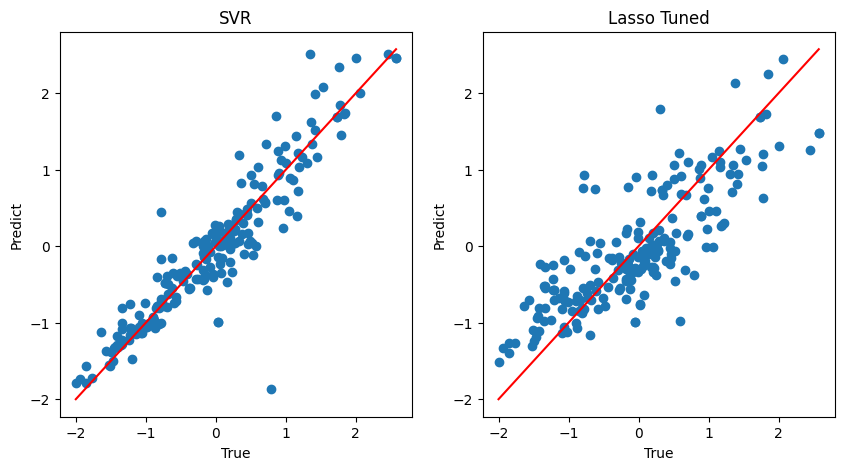

In [61]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(y_test_std, grid_rbf_pred, label = 'SVR')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('SVR')
plt.subplot(1,2,2)
plt.scatter(y_test_std, grid_lasso_pred_test, label = 'SVR')
plt.plot([min(y_test_std), max(y_test_std)], [min(y_test_std), max(y_test_std)], color = 'red')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Lasso Tuned')
plt.show()